In [63]:
import pickle
from warnings import filterwarnings
filterwarnings('ignore')
from IPython.core.display import HTML, display

import numpy as np
import pandas as pd

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from theano import shared
import theano.tensor as tt
import pymc3 as pm
from tqdm import tqdm

import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib.ticker import FuncFormatter
from seaborn import PairGrid, heatmap, kdeplot
import cmocean.cm as cmo
from pymc_utils import PyMCModel
from pymc_utils import subset_significant_feature
from pymc_utils import lasso_regression, hs_regression
from pymc_utils import plot_fits_w_estimates

In [12]:
% matplotlib inline
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16
display(HTML("<style>.container{width: 90% !important}</style>"))

In [14]:
df_aphy_wi = pd.read_pickle('./pickleJar/OperationalDataSets/df_6_APHY_Standardized_PolyFeatures_SWF_PC_lim.pkl')

In [15]:
df_aphy_wi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162 entries, 2 to 494
Data columns (total 51 columns):
log10_etopo2_s            162 non-null float64
oisst_s                   162 non-null float64
solz_s                    162 non-null float64
PC1_s                     162 non-null float64
PC2_s                     162 non-null float64
PC3_s                     162 non-null float64
PC4_s                     162 non-null float64
PC5_s                     162 non-null float64
PC6_s                     162 non-null float64
log10_etopo2_s oisst_s    162 non-null float64
log10_etopo2_s solz_s     162 non-null float64
log10_etopo2_s PC1_s      162 non-null float64
log10_etopo2_s PC2_s      162 non-null float64
log10_etopo2_s PC3_s      162 non-null float64
log10_etopo2_s PC4_s      162 non-null float64
log10_etopo2_s PC5_s      162 non-null float64
log10_etopo2_s PC6_s      162 non-null float64
oisst_s solz_s            162 non-null float64
oisst_s PC1_s             162 non-null float64
oi

In [16]:
df_aphy_wi['log10_aphy411'] = np.log10(df_aphy_wi.aphy411)
df_aphy_wi['log10_aphy443'] = np.log10(df_aphy_wi.aphy443)
df_aphy_wi['log10_aphy489'] = np.log10(df_aphy_wi.aphy489)
df_aphy_wi['log10_aphy510'] = np.log10(df_aphy_wi.aphy510)
df_aphy_wi['log10_aphy555'] = np.log10(df_aphy_wi.aphy555)
df_aphy_wi['log10_aphy670'] = np.log10(df_aphy_wi.aphy670)

In [17]:
aphys = df_aphy_wi.filter(regex='^aphy').columns
df_aphy_wi.drop(aphys, axis=1, inplace=True)

In [18]:
df_aphy_wi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162 entries, 2 to 494
Data columns (total 51 columns):
log10_etopo2_s            162 non-null float64
oisst_s                   162 non-null float64
solz_s                    162 non-null float64
PC1_s                     162 non-null float64
PC2_s                     162 non-null float64
PC3_s                     162 non-null float64
PC4_s                     162 non-null float64
PC5_s                     162 non-null float64
PC6_s                     162 non-null float64
log10_etopo2_s oisst_s    162 non-null float64
log10_etopo2_s solz_s     162 non-null float64
log10_etopo2_s PC1_s      162 non-null float64
log10_etopo2_s PC2_s      162 non-null float64
log10_etopo2_s PC3_s      162 non-null float64
log10_etopo2_s PC4_s      162 non-null float64
log10_etopo2_s PC5_s      162 non-null float64
log10_etopo2_s PC6_s      162 non-null float64
oisst_s solz_s            162 non-null float64
oisst_s PC1_s             162 non-null float64
oi

In [19]:
def PlotHeatMap(df, ax=None,):
    if ax is None:
        _, ax = pl.subplots(figsize=(20, 20))
    dfc = df.corr().iloc[1:, :-1]
    heatmap(dfc, vmin=-1, vmax=1, cmap=cmo.balance_r, annot=True, annot_kws={'fontsize': 13},
            ax=ax, mask=np.triu(np.ones([dfc.shape[1]]*2), k=1), fmt='.1f')
    ax.set_facecolor('k')
    return ax


def plot_obs_against_ppc(y_obs, ppc, ax=None, plot_1_to_1=False, **scatter_kwds):
    if ax is None:
        _, ax = pl.subplots(figsize=(10, 10))
    ppc_mean = ppc.mean(axis=0)
    ax.scatter(y_obs, ppc_mean, edgecolor='k', **scatter_kwds)
    if plot_1_to_1:
        min_ = min(ppc_mean.min(), y_obs.min())
        max_ = max(ppc_mean.max(), y_obs.max())
        ax.plot([min_, max_], [min_, max_], ls='--', color='k', label='1:1')


def evaluate_model(model,  y_train_, y_test_, ax1_title=None, ax2_title=None, ax3_title=None,):
    f = pl.figure(figsize=(15, 15))
    ax1 = pl.subplot2grid((2, 2), (0, 0))
    ax2 = pl.subplot2grid((2, 2), (0, 1))
    ax3 = pl.subplot2grid((2, 2), (1, 0), colspan=2)
    X_shared.set_value(X_s_train.values)
    ppc_train_ = model.predict(likelihood_name='likelihood' )
    model.plot_model_fits(y_train_, ppc_train_, loss_metric='mae',
                          ax=ax1, title=ax1_title, );
    X_shared.set_value(X_s_test.values)
    ppc_test_ = model.predict(likelihood_name='likelihood')
    model.plot_model_fits(y_test_, ppc_test_, loss_metric='mae',
                          ax=ax2, title=ax2_title, );
    plot_fits_w_estimates(y_test_, ppc_test_, ax=ax3)
    ax3.set_title(ax3_title)
    return f, ppc_train_, ppc_test_

def plot_fits_w_estimates(y_obs, ppc, ax=None, savename=False, steps=3):
    """ Plot Fits with Uncertainty Estimates"""
    iy  = np.argsort(y_obs)
    ix = np.arange(iy.size)
    lik_mean =ppc.mean(axis=0)
    lik_hpd = pm.hpd(ppc)
    lik_hpd_05 = pm.hpd(ppc, alpha=0.5)
    if ax is None:
        _, ax = pl.subplots(figsize=(12, 8))
    if steps > 2:
        ax.scatter(ix, y_obs.values[iy], label='observed', edgecolor='k', s=120,
                   color='steelblue', marker='d', zorder=2);
    if steps > 1:
        ax.scatter(ix, lik_mean[iy], label='model mean', edgecolor='k', s=80,
                   color='m', zorder=3)
    
    ax.fill_between(ix, y1=lik_hpd_05[iy, 0], y2=lik_hpd_05[iy, 1], color='gray', 
                   label='model output 50%CI', zorder=1,linestyle='-', lw=2, edgecolor='k');
    ax.fill_between(ix, y1=lik_hpd[iy, 0], y2=lik_hpd[iy, 1], color='k', alpha=0.75,
                   label='model output 95%CI', zorder=0, );
    ax.legend(loc='upper left');
    if savename:
        f = pl.gcf()
        f.savefig('./figJar/bayesNet/bNN_L1_nobias.pdf', format='pdf')
    return ax

### <u>Modeling</u>

Below the smaller dataset (no interactions features one entry where all PC's are NaNs.
I just drop that row for now. To impute the missing predictors is a bit more complicated than when predicted values are missing.

In [21]:
feat_end_ni = 'PC5_s PC6_s'
X_s = df_aphy_wi.loc[:, :feat_end_ni]
y = df_aphy_wi.loc[:, 'log10_aphy411':]

In [22]:
feature_labels=df_aphy_wi.loc[:,:feat_end_ni].columns.tolist()

In [23]:
X_s_train, X_s_test, y_train, y_test = train_test_split(X_s, y, test_size=0.1,
                                                       random_state=42)

### A$\phi$ 411

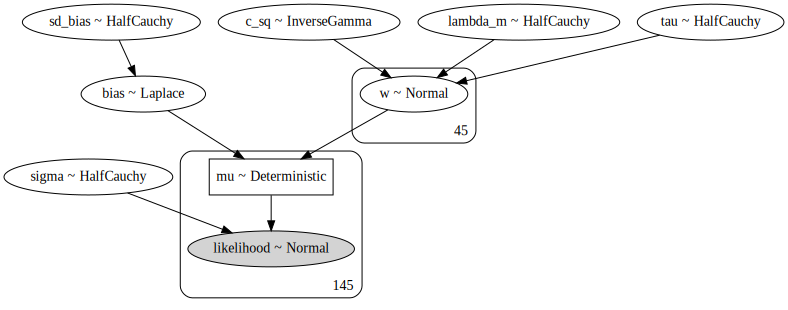

In [24]:
X_shared = shared(X_s_train.values)
m_hshoe_411 = PyMCModel(hs_regression, X_shared, y_train.log10_aphy411, model_name='hshoe_aphy411_wi',
                        ylabel='likelihood', regularized=True)
m_hshoe_411.show_model()

In [25]:
m_hshoe_411.fit(tune=7000, cores=1, chains=4, nuts_kwargs=dict(target_accept=0.9))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, bias, w, c_sq, lambda_m, sd_bias, tau]
100%|██████████| 9000/9000 [01:17<00:00, 116.19it/s]


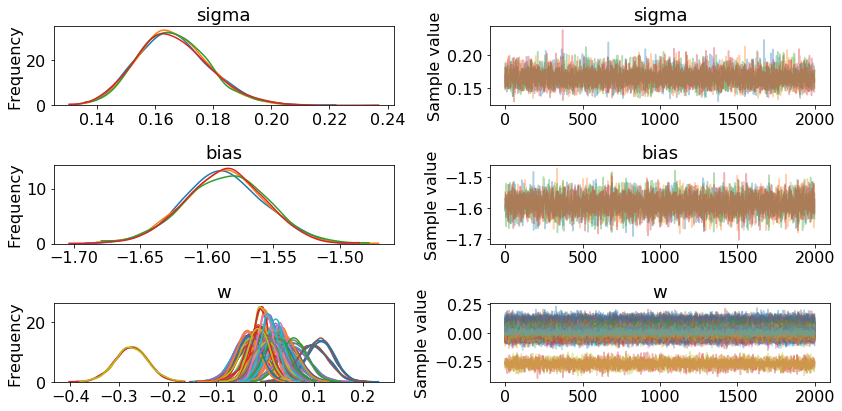

In [26]:
m_hshoe_411.evaluate_fit(['sigma',  'bias', 'w']);

In [27]:
significant_features = subset_significant_feature(m_hshoe_411.trace_, feature_labels, vars_=['w'])

In [28]:
significant_features

['PC1_s', 'PC3_s', 'solz_s PC4_s', 'PC1_s PC2_s']

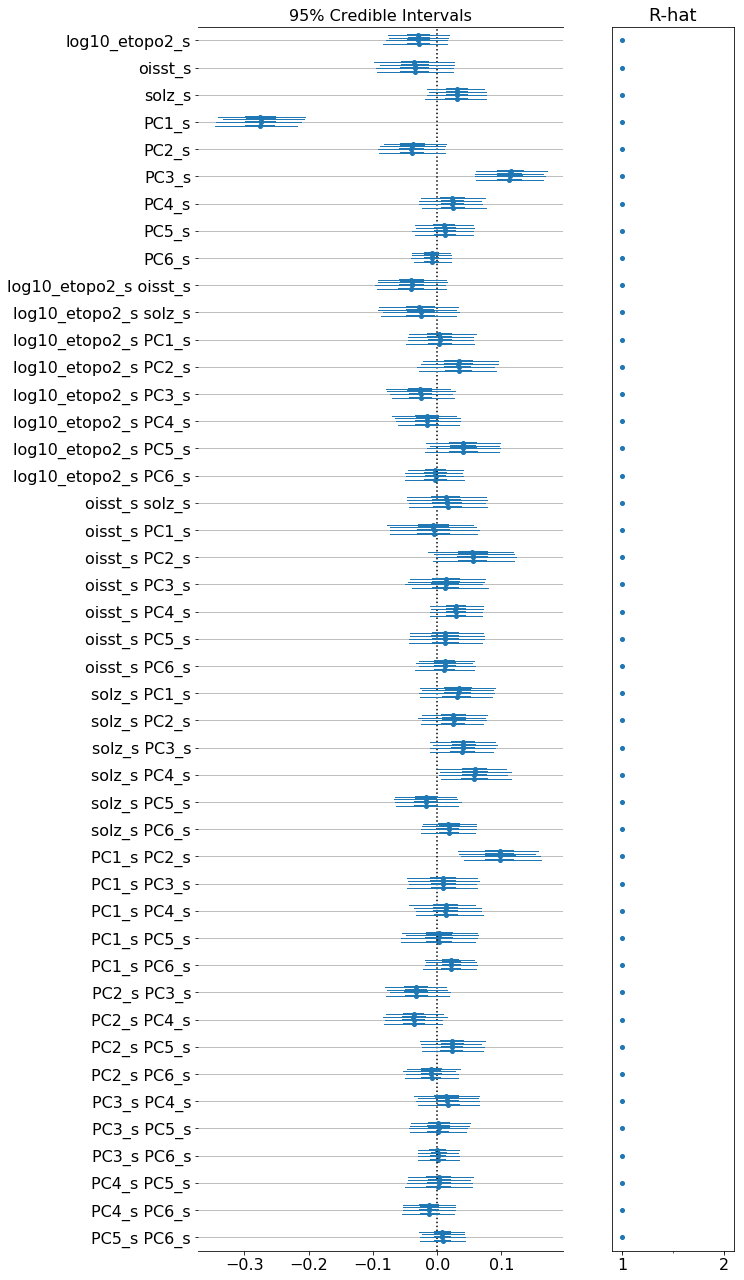

In [31]:
m_hshoe_411.show_forest(['w'], feat_labels=feature_labels);
f = pl.gcf()
f.set_figheight(20)
f.set_figwidth(12)
#f.savefig('./figJar/APHI411_foresplot.png', dpi=300, format='png')

In [44]:
X_shared.set_value(X_s_train)

In [47]:
ppc_train_411 = m_hshoe_411.predict(likelihood_name='likelihood')

100%|██████████| 2000/2000 [00:01<00:00, 1723.88it/s]


In [48]:
ppc_train_411.shape, ppc_test_411.shape

((2000, 145), (2000, 17))

In [50]:
with open('../../WRITEUPS/TOA_ML_Writeup/hs_model_wi_411.pkl', 'wb') as f:
    pickle.dump(m_hshoe_411, f)

In [ ]:
X_shared.set_value(X_s_test.values)
ppc_test_411 = m_hshoe_411.predict(likelihood_name='likelihood')

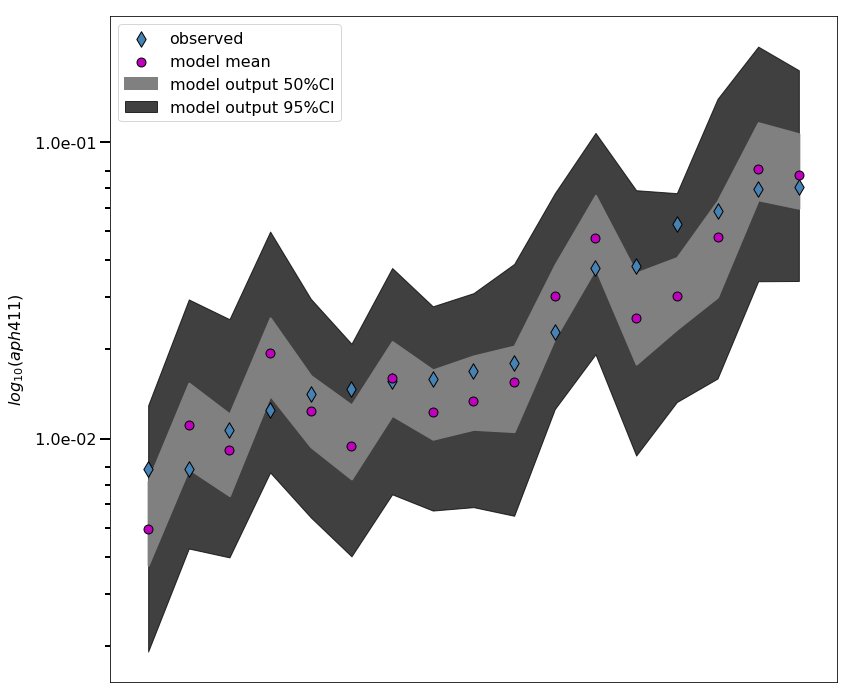

In [53]:
f, ax = pl.subplots(figsize=(12, 10))
ax = plot_fits_w_estimates(y_test.log10_aphy411, ppc_test_411, ax=ax)
ax.set_xticklabels([]);
ax.set_ylabel('$log_{10}(aph 411)$')
ax.set_yticks(np.log10(np.asarray([1e-2, 1e-1])))
minor_ticks = np.concatenate((np.arange(2e-3, 9e-3, 1e-3), np.arange(2e-2, 9e-2, 1e-2)))
ax.set_yticks(np.log10(minor_ticks), minor=True)
ax.tick_params(axis='y', which='minor', length=5, width=2)
ax.tick_params(axis='y', which='major', length=10, width=2)
ax.tick_params(axis='x', which='both', length=0, width=0)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{10**x: .1e}'))
f.tight_layout()
f.savefig('../../WRITEUPS/TOA_ML_Writeup/FigJar/ppc_2_hs_wi_aphi_411.pdf', dpi=300, format='pdf')

In [56]:
with open('../../WRITEUPS/TOA_ML_Writeup/ppc_2.pkl', 'wb') as fb:
    picledict = dict(ytest=y_test.log10_aphy411.values, ppc=ppc_test_411)
    pickle.dump(picledict, fb)

### A$\phi$ 443

In [84]:
X_shared.set_value(X_s_train.values)
m_hshoe_443 = PyMCModel(hs_regression, X_shared, y_train.log10_aphy443, model_name='hshoe_aphy443_wi',
                        ylabel='likelihood', regularized=True)
m_hshoe_443.fit(tune=7000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bias, w, c_sq, lambda_m, sd_bias, tau]
Sampling 4 chains: 100%|██████████| 36000/36000 [01:11<00:00, 500.28draws/s]
There were 284 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7158720072078956, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8999623456815528, but should be close to 0.8. Try to increase the number of tuning steps.
There were 236 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.675039687572507, but should be close to 0.8. Try to increase the number of tuning steps.


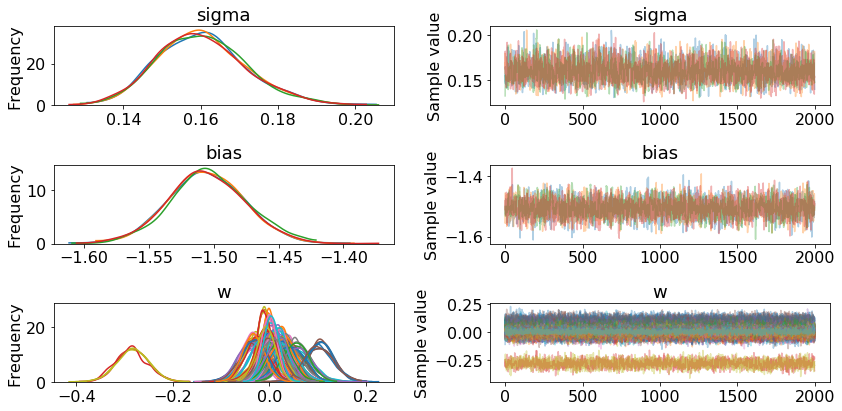

In [61]:
m_hshoe_443.evaluate_fit(['sigma',  'bias', 'w']);

In [70]:
X_shared.set_value(X_s_test.values)
ppc_test_443 = m_hshoe_443.predict(likelihood_name='likelihood')

100%|██████████| 2000/2000 [00:01<00:00, 1264.44it/s]


### A$\phi$ 489

In [86]:
X_shared.set_value(X_s_train.values)
m_hshoe_489 = PyMCModel(hs_regression, X_shared, y_train.log10_aphy489, model_name='hshoe_aphy489_wi',
                        ylabel='likelihood', regularized=True)
m_hshoe_489.fit(tune=7000, nuts_kwargs=dict(target_accept=0.85))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bias, w, c_sq, lambda_m, sd_bias, tau]
Sampling 4 chains: 100%|██████████| 36000/36000 [01:18<00:00, 458.67draws/s]


In [75]:
X_shared.set_value(X_s_test.values)
ppc_test_489 = m_hshoe_489.predict(likelihood_name='likelihood')

100%|██████████| 2000/2000 [00:01<00:00, 1254.19it/s]


In [76]:
X_shared.set_value(X_s_train.values)
m_hshoe_510 = PyMCModel(hs_regression, X_shared, y_train.log10_aphy510, model_name='hshoe_aphy510_wi',
                        ylabel='likelihood', regularized=True)
m_hshoe_510.fit(tune=7000, nuts_kwargs=dict(target_accept=0.85))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bias, w, c_sq, lambda_m, sd_bias, tau]
Sampling 4 chains: 100%|██████████| 36000/36000 [01:19<00:00, 454.87draws/s]
There were 110 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6988243094002018, but should be close to 0.85. Try to increase the number of tuning steps.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7172281992719134, but should be close to 0.85. Try to increase the number of tuning steps.


In [78]:
X_shared.set_value(X_s_test.values)
ppc_test_510 = m_hshoe_510.predict(likelihood_name='likelihood')

100%|██████████| 2000/2000 [00:01<00:00, 1252.33it/s]


In [79]:
X_shared.set_value(X_s_train.values)
m_hshoe_555 = PyMCModel(hs_regression, X_shared, y_train.log10_aphy555, model_name='hshoe_aphy555',
                        ylabel='likelihood', regularized=True)
m_hshoe_555.fit(tune=7000, nuts_kwargs=dict(target_accept=0.85))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bias, w, c_sq, lambda_m, sd_bias, tau]
Sampling 4 chains: 100%|██████████| 36000/36000 [01:17<00:00, 462.18draws/s]
There were 209 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6978720231385186, but should be close to 0.85. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 251 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7142313141730431, but should be close to 0.85. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


In [80]:
X_shared.set_value(X_s_test.values)
ppc_test_555 = m_hshoe_555.predict(likelihood_name='likelihood')

100%|██████████| 2000/2000 [00:01<00:00, 1243.88it/s]


In [81]:
X_shared.set_value(X_s_train.values)
m_hshoe_670 = PyMCModel(hs_regression, X_shared, y_train.log10_aphy670, model_name='hshoe_aphy670_wi',
                        ylabel='likelihood', regularized=True)
m_hshoe_670.fit(tune=7000, nuts_kwargs=dict(target_accept=0.85))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bias, w, c_sq, lambda_m, sd_bias, tau]
Sampling 4 chains: 100%|██████████| 36000/36000 [01:23<00:00, 126.08draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 217 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5076841617435461, but should be close to 0.85. Try to increase the number of tuning steps.


In [82]:
X_shared.set_value(X_s_test.values)
ppc_test_670 = m_hshoe_670.predict(likelihood_name='likelihood')

100%|██████████| 2000/2000 [00:01<00:00, 1273.77it/s]


In [34]:
X_shared.set_value(X_s_train.values)
pickleModelDict = {m_hshoe_411.model.name: m_hshoe_411, 
                   m_hshoe_443.model.name: m_hshoe_443,
                   m_hshoe_489.model.name: m_hshoe_489,
                   m_hshoe_510.model.name: m_hshoe_510,
                   m_hshoe_555.model.name: m_hshoe_555,
                   m_hshoe_670.model.name: m_hshoe_670}
with open('./pickleJar/Models/HS_Prior_With_Int_All_APhys.pkl', 'wb') as f:
    pickle.dump(pickleModelDict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [87]:
mae_411 = mean_absolute_error(y_test.log10_aphy411.values, ppc_test_411.mean(axis=0))
mae_443 = mean_absolute_error(y_test.log10_aphy443.values, ppc_test_443.mean(axis=0))
mae_489 = mean_absolute_error(y_test.log10_aphy489.values, ppc_test_489.mean(axis=0))
mae_510 = mean_absolute_error(y_test.log10_aphy510.values, ppc_test_510.mean(axis=0))
mae_555 = mean_absolute_error(y_test.log10_aphy555.values, ppc_test_555.mean(axis=0))
mae_670 = mean_absolute_error(y_test.log10_aphy670.values, ppc_test_670.mean(axis=0))

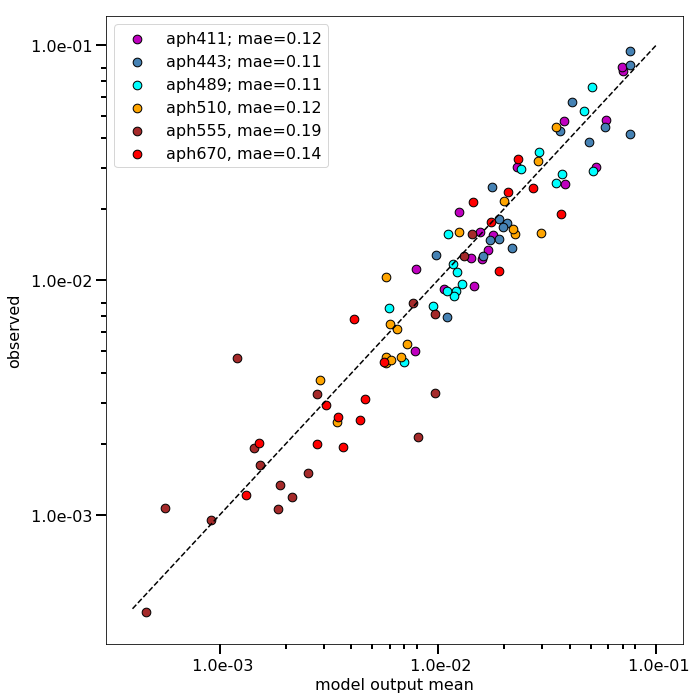

In [93]:
minor_ticks = np.concatenate((np.arange(5e-4, 9e-4, 1e-4), np.arange(2e-3, 9e-3, 1e-3),
                              np.arange(2e-2, 9e-2, 1e-2)))
f, ax_ = pl.subplots(figsize=(10, 10))
plot_obs_against_ppc(y_test.log10_aphy411, ppc_test_411, color='m',
                     label=f'aph411; mae={mae_411:.2f}', s=75, ax=ax_) 
plot_obs_against_ppc(y_test.log10_aphy443, ppc_test_443, color='steelblue', ax=ax_,
                     label=f'aph443; mae={mae_443:.2f}', s=75,)
plot_obs_against_ppc(y_test.log10_aphy489, ppc_test_489, color='cyan', ax=ax_,
                     label=f'aph489; mae={mae_489:.2f}', s=75, )
plot_obs_against_ppc(y_test.log10_aphy510, ppc_test_510, color='orange', ax=ax_,
                     label=f'aph510, mae={mae_510:.2f}', s=75,)
plot_obs_against_ppc(y_test.log10_aphy555, ppc_test_555, color='brown', ax=ax_,
                     label=f'aph555, mae={mae_555:.2f}', s=75, )
plot_obs_against_ppc(y_test.log10_aphy670, ppc_test_670, color='red', ax=ax_,
                     label=f'aph670, mae={mae_670:.2f}', s=75, )
ax_.plot([-3.4, -1], [-3.4, -1], color='k', ls='--')
ax_.legend()
ax_.set_xlabel('model output mean')
ax_.set_ylabel('observed')
ax_.set_yticks(np.log10(np.asarray([1e-3, 1e-2, 1e-1])))
ax_.set_xticks(np.log10(np.asarray([1e-3, 1e-2, 1e-1])))
ax_.set_yticks(np.log10(minor_ticks), minor=True)
ax_.set_xticks(np.log10(minor_ticks), minor=True)
ax_.tick_params(axis='both', which='minor', length=5, width=2)
ax_.tick_params(axis='both', which='major', length=10, width=2)
ax_.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{10**x: .1e}'))
ax_.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{10**x: .1e}'))
f.tight_layout()
f.savefig('../../WRITEUPS/TOA_ML_Writeup/FigJar/test_2.pdf', format='pdf', dpi=300)

In [91]:
with open('../../WRITEUPS/TOA_ML_Writeup/test2.pkl', 'wb') as fb:
    test_dict = dict(y_test = y_test,
                    ppc={'411': ppc_test_411, '443': ppc_test_443, '489': ppc_test_489,
                        '510': ppc_test_510, '555': ppc_test_555, '670': ppc_test_670},
                    mae={'411': mae_411, '443': mae_443, '489': mae_489, '510': mae_510,
                        '555': mae_555, '670': mae_670})
    pickle.dump(test_dict, fb)